In [33]:
import pandas as pd
from plotnine import *
from tensorflow import keras
from keras import models
from keras import layers
from keras import losses
from tensorflow.keras import optimizers
from keras import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn import metrics
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt

In [2]:
db=pd.read_csv("games.csv")
db.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


## Checking to see if different traits increase likelyhood of winning

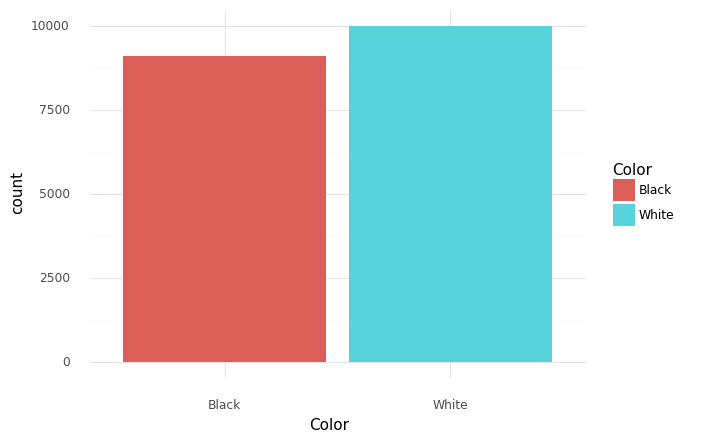

<ggplot: (117206091283)>

In [3]:
white=(db["winner"]=="white").sum()
black=(db["winner"]=="black").sum()
colorWinDb=pd.DataFrame({"Color": ["White", "Black"], 
                        "y":[white, black]})
(ggplot(colorWinDb, aes(x="Color", weight="y", fill="Color"))+geom_bar()+theme_minimal())

As expected there is no significant difference in wins whether the player was using the white pieces or black pieces. It also makes sense that there are slightly more wins for white since they start first. 

## Checking to see if rating makes a difference in predicting who is going to win 

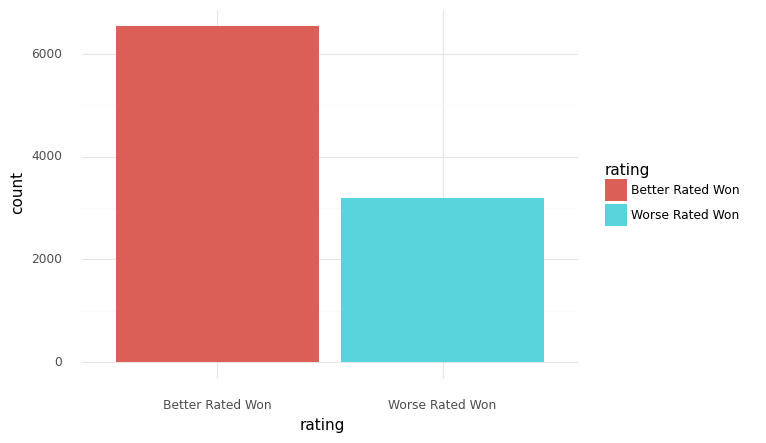

<ggplot: (117206464275)>

In [4]:
whiteBetter=0
blackBetter=0
whiteWorse=0
blackWorse=0
for index, row in db.iterrows():
    if((int(row["white_rating"])>int(row["black_rating"]) and row["winner"]=="white")):
        whiteBetter+=1
    elif(int(row["white_rating"])<int(row["black_rating"] and row["winner"]=="black")):
        blackBetter+=1
    elif(int(row["white_rating"])<int(row["black_rating"] and row["winner"]=="white")):
        whiteWorse+=1
    elif((int(row["white_rating"])>int(row["black_rating"]) and row["winner"]=="black")):
        blackWorse+=1
ratingWinDb=pd.DataFrame({"rating": ["Better Rated Won", "Worse Rated Won"], 
                        "y":[whiteBetter+blackBetter, blackWorse+whiteWorse]})
(ggplot(ratingWinDb, aes(x="rating", weight="y", fill="rating"))+geom_bar()+theme_minimal())



In [5]:
total=whiteBetter+blackBetter+blackWorse+whiteWorse
percent=float(((whiteBetter+blackBetter)/total)*100)
print(str(percent)+"% of better rated players won in their matchup vs a worse rated player")

67.18460588598477% of better rated players won in their matchup vs a worse rated player


This shows that a players rating is a big factor in determining whether a player will win in a matchup. The problem with this is that ratings don't carry over to playing on different sites or playing someone in real life. 

## Predicting who will win a game based off of the first couple moves

### Getting data ready

In [3]:
db["winner"] = db["winner"].astype('category')
db['winner_code']=db["winner"].cat.codes

db["opening_eco"]=db["opening_eco"].astype('category')
db["opening_eco_code"]=db["opening_eco"].cat.codes

db["opening_name"]=db["opening_name"].astype('category')
db["opening_name_code"]=db["opening_name"].cat.codes

db["victory_status"]=db["victory_status"].astype('category')
db["victory_status_code"]=db["victory_status"].cat.codes

db["increment_code"]=db["increment_code"].astype('category')
db["increment_code_num"]=db["increment_code"].cat.codes

In [8]:
predictors=["turns","opening_ply", "opening_eco_code", "opening_name_code", "victory_status_code", "increment_code_num" ]


In [9]:
x_train, x_test, y_train, y_test =train_test_split(db[predictors], db["winner_code"], test_size=.2)

16046

### Building and testing model

In [11]:
clf = svm.SVC(kernel='linear')



In [12]:
clf.fit(x_train, y_train)


SVC(kernel='linear')

In [13]:
y_pred = clf.predict(x_test)

In [14]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5396311066799602


This accuracy isn't very high and is only slightly better than guessing. Adding the rating can make it a little better. This also shows that opening moves are not the best way to predict the winner as its only slightly better than guessing

### Adding the ratings of the players to improve the model

In [15]:
predictors=["turns","opening_ply", "opening_eco_code", "opening_name_code", "victory_status_code", "increment_code_num", 
           "white_rating", "black_rating"]
x_train, x_test, y_train, y_test =train_test_split(db[predictors], db["winner_code"], test_size=.2)

In [16]:
clf = svm.SVC(kernel='linear')

In [17]:
clf.fit(x_train, y_train)


SVC(kernel='linear')

In [18]:
y_pred = clf.predict(x_test)

In [19]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6707377866400798


I can see that the accuracy improved once the ratings were added of each player. This makes sense as we saw there was a correlation with ratings and who wins the game. However, ratings are only relevant on this site and don't transfer over when a game is played on a different site or in real life. This concludes that the opening play is not the best metric to predict who the winner of a game will be

## Guessing the next move with Feed Forward Neural Network

In [101]:
data = {'Move1':[],
        'Move2':[]}
moveDf = pd.DataFrame(data)


In [102]:
moveDf.head()

,Move1,Move2


This takes a couple hours to make this dataset, for a shortcut use the block that will load in the premade dataset that has been made before

In [103]:
counter=0
for i in db["moves"] :
    moves=i.split(" ")
    #print(moves)
    counter=0
    temp=[]
    for j in moves:
        temp.append(j)
        if(counter%2==1):
            moveDf=moveDf.append({'Move1':temp[counter-1], 'Move2':temp[counter]}, ignore_index=True)
            #print(moveDf.head())
        counter+=1
    

In [ ]:
moveDf["Move1"] = moveDf["Move1"].astype('category')
moveDf["Move1Code"]=moveDf["Move1"].cat.codes

moveDf["Move2"] = moveDf["Move2"].astype('category')
moveDf["Move2Code"] = moveDf["Move2"].cat.codes

In [4]:
moveDf["PreviousMove2Code"]=moveDf["Move2Code"].shift(1)
moveDf['PreviousMove2Code'] = moveDf['PreviousMove2Code'].fillna(0)
moveDf.head()

,Move1,Move2,Move1Code,Move2Code,PreviousMove2Code
0,d4,d5,2675,2997,0.0
1,c4,c6,2635,2955,2997.0
2,cxd5,e6,2665,3042,2955.0
3,dxe6,fxe6,2705,3101,3042.0
4,Nf3,Bb4+,752,27,3101.0


**Shortcut**

In [3]:
moveDf=pd.read_csv("moveDf.csv")

In [5]:
len(moveDf)

601253

In [6]:
moveDf.head()

,Move1,Move2,Move1Code,Move2Code,PreviousMove2Code
0,d4,d5,2675,2997,0.0
1,c4,c6,2635,2955,2997.0
2,cxd5,e6,2665,3042,2955.0
3,dxe6,fxe6,2705,3101,3042.0
4,Nf3,Bb4+,752,27,3101.0


In [7]:
predictors=["Move1Code", "PreviousMove2Code"]

In [8]:
x_train, x_test, y_train, y_test =train_test_split(moveDf[predictors], moveDf["Move2Code"], test_size=.2)

In [9]:
x_val=x_train[:50000]
partial_x_train = x_train[50000:]
y_val=y_train[:50000]
partial_y_train = y_train[50000: ]

<AxesSubplot:ylabel='Density'>

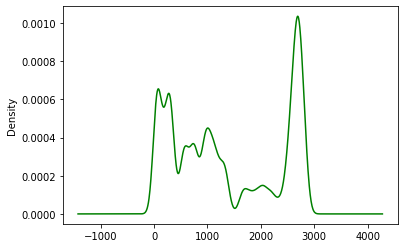

In [23]:
moveDf.Move1Code.plot.density(color='green')


<AxesSubplot:ylabel='Density'>

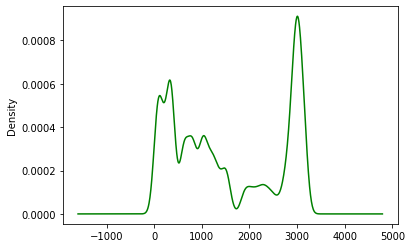

In [24]:
moveDf.Move2Code.plot.density(color='green')


In [25]:
clf = svm.SVC(kernel='linear')

In [ ]:
clf.fit(x_train, y_train)

In [ ]:
y_pred = clf.predict(x_test)

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

In [10]:
from sklearn.svm import SVR
regressor = SVR(kernel = 'rbf')

In [11]:
regressor.fit(x_train, y_train)

SVR()

In [12]:
y_predr = regressor.predict(x_test)

In [20]:
y_predr

array([1629.9714457 , 1366.66999598,  907.14824985, ..., 1325.48792455,
       1326.90523942, 2268.83794081])

In [44]:
print("Mean Absolute Error",metrics.mean_absolute_error(y_test, y_predr))

Mean Absolute Error 983.3078590926864


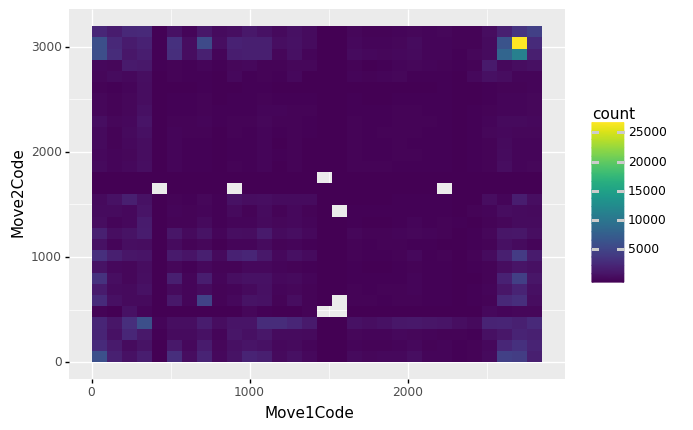

<ggplot: (110571151267)>

In [56]:
(ggplot(moveDf, aes(x="Move1Code", y="Move2Code"))+geom_bin2d())

In [60]:
model=models.Sequential()
model.add(layers.Dense(64, activation = 'relu', input_shape=(2,)))
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(1, activation= 'sigmoid'))

model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['accuracy']) 

history = model.fit(partial_x_train,                    
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))
results=model.evaluate(x_test, y_test)
results

Epoch 1/20
842/842 [==============================] - 1s 1ms/step - loss: 1547.5775 - accuracy: 2.3202e-05 - val_loss: 1550.0104 - val_accuracy: 4.0000e-05
Epoch 2/20
842/842 [==============================] - 1s 1ms/step - loss: 1547.5786 - accuracy: 2.3202e-05 - val_loss: 1550.0104 - val_accuracy: 4.0000e-05
Epoch 3/20
842/842 [==============================] - 1s 1ms/step - loss: 1547.5782 - accuracy: 2.3202e-05 - val_loss: 1550.0104 - val_accuracy: 4.0000e-05
Epoch 4/20
842/842 [==============================] - 1s 1ms/step - loss: 1547.5782 - accuracy: 2.3202e-05 - val_loss: 1550.0104 - val_accuracy: 4.0000e-05
Epoch 5/20
842/842 [==============================] - 1s 1000us/step - loss: 1547.5775 - accuracy: 2.3202e-05 - val_loss: 1550.0104 - val_accuracy: 4.0000e-05
Epoch 6/20
842/842 [==============================] - 1s 1ms/step - loss: 1547.5785 - accuracy: 2.3202e-05 - val_loss: 1550.0104 - val_accuracy: 4.0000e-05
Epoch 7/20
842/842 [==============================] - 1s 995u

[1541.837158203125, 1.663187867961824e-05]

In [117]:
moveDf.to_csv('moveDf.csv', index = False, header=True)
#saving it so it doesn't have to be built next time

In [28]:
model.predict([1000])

array([[1.]], dtype=float32)